<a href="https://colab.research.google.com/github/NathanDietrich/Artificial-Intelligence-and-Machine-Learning-portfolio/blob/main/DataCollectionFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance textblob ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3a8998bf64549fa9fabc68f776f6b7506e88ec30939ed6856f092d5df2ff44f8
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [15]:
import os
import requests
import datetime
import pandas as pd
import time
from google.colab import userdata  # For fetching stored API keys
from textblob import TextBlob

# >>> Added lines to mount Google Drive <<<
from google.colab import drive
drive.mount('/content/drive')

def fetch_stock_data_polygon(ticker, start_date, end_date, api_key):
    """
    Fetches historical stock data from Polygon.io.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}?apiKey={api_key}"
    response = requests.get(url)

    if response.status_code != 200:
        print(f"Error fetching stock data: {response.text}")
        return None

    data = response.json()
    if "results" not in data:
        print("No results found.")
        return None

    # Convert response to DataFrame
    df = pd.DataFrame(data["results"])
    df["Date"] = pd.to_datetime(df["t"], unit="ms").dt.date
    df.rename(columns={"o": "Open", "h": "High", "l": "Low", "c": "Close", "v": "Volume"}, inplace=True)
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]

    return df

def fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000):
    """
    Fetches sentiment data from Polygon.io in chunks and computes daily sentiment scores.
    """
    url = "https://api.polygon.io/v2/reference/news"
    all_results = []
    current_start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    final_end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")

    while current_start_date < final_end_date:
        chunk_end_date = current_start_date + datetime.timedelta(days=30)
        if chunk_end_date > final_end_date:
            chunk_end_date = final_end_date

        chunk_start_str = current_start_date.strftime("%Y-%m-%d")
        chunk_end_str = chunk_end_date.strftime("%Y-%m-%d")

        print(f"📡 Fetching sentiment data from {chunk_start_str} to {chunk_end_str}...")

        params = {
            "ticker": ticker,
            "published_utc.gte": chunk_start_str,
            "published_utc.lte": chunk_end_str,
            "apiKey": api_key,
            "limit": limit
        }

        while True:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                results = data.get("results", [])
                all_results.extend(results)

                next_cursor = data.get("next_cursor")
                if not next_cursor:
                    break

                params["cursor"] = next_cursor
            else:
                print(f"⚠️ Error fetching sentiment data: {response.status_code}, {response.text}")
                break

        current_start_date = chunk_end_date
        time.sleep(14)  # Avoid hitting API rate limits

    return all_results

def analyze_sentiment(news_data):
    """
    Uses TextBlob to compute sentiment polarity and subjectivity for each news article.
    """
    analyzed_data = []
    for article in news_data:
        title = article.get("title", "")
        description = article.get("description", "")
        full_text = f"{title} {description}"
        sentiment = TextBlob(full_text).sentiment

        analyzed_data.append({
            "title": title,
            "description": description,
            "published_date": article.get("published_utc", ""),
            "sentiment_polarity": sentiment.polarity,
            "sentiment_subjectivity": sentiment.subjectivity
        })

    return analyzed_data

def merge_stock_and_sentiment(stock_df, sentiment_data):
    """
    Merges stock data with sentiment data by date.
    """
    sentiment_df = pd.DataFrame(sentiment_data)

    if sentiment_df.empty:
        print("⚠️ No sentiment data found, proceeding without sentiment.")
        stock_df["sentiment_polarity"] = 0  # Default neutral
        stock_df["sentiment_subjectivity"] = 0
        return stock_df

    sentiment_df['published_date'] = pd.to_datetime(sentiment_df['published_date'], errors='coerce')
    sentiment_df['Date'] = sentiment_df['published_date'].dt.date

    # Group sentiment data by date
    daily_sentiment = sentiment_df.groupby('Date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    # Merge with stock data
    merged_df = pd.merge(stock_df, daily_sentiment, on="Date", how="left")

    # Handle missing sentiment values (forward fill) while ensuring numeric dtype
    merged_df[['sentiment_polarity', 'sentiment_subjectivity']] = (
        merged_df[['sentiment_polarity', 'sentiment_subjectivity']]
        .replace(0, pd.NA)  # Convert zeros to NaN
        .infer_objects(copy=False)  # Ensure numeric dtype
        .ffill()  # Forward fill missing values
    )
    # Fill any remaining NaN values
    merged_df.fillna(0, inplace=True)

    return merged_df

def main():
    """
    Main function to fetch stock data and sentiment data, merge them, and save to a raw CSV file.
    """
    # Get today's date
    today = datetime.date.today().strftime("%Y-%m-%d")

    # Set fixed start date
    start_date = "2021-01-01"
    end_date = today

    # Ask user for stock ticker
    ticker = input("Enter the stock ticker (e.g., TSLA): ").strip().upper()

    # Load Polygon API key
    api_key = userdata.get("Polygon_Key")
    if not api_key:
        print("❌ Error: Polygon API key not found.")
        return

    # Fetch stock data
    print(f"\n📊 Fetching stock data for {ticker} from {start_date} to {end_date}...")
    stock_df = fetch_stock_data_polygon(ticker, start_date, end_date, api_key)

    if stock_df is None:
        print("❌ No stock data found. Exiting.")
        return

    # Fetch sentiment data
    print(f"\n📰 Fetching sentiment data for {ticker} from {start_date} to {end_date}...")
    news_data = fetch_sentiment_data_polygon(ticker, start_date, end_date, api_key, limit=1000)

    if not news_data:
        print("⚠️ No news data found. Proceeding without sentiment data.")

    print("\n💡 Performing sentiment analysis...")
    sentiment_data = analyze_sentiment(news_data)

    # Merge stock and sentiment data
    print("\n🔗 Merging stock and sentiment data...")
    merged_df = merge_stock_and_sentiment(stock_df, sentiment_data)

    # >>> Changed the path so it saves into "My Drive/StockData" <<<
    filename = f"/content/drive/My Drive/StockData/{ticker}_{start_date}_to_{end_date}_raw.csv"
    merged_df.to_csv(filename, index=False)
    print(f"✅ Raw stock data with sentiment saved to: {filename}")

# Run the main function
if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Enter the stock ticker (e.g., TSLA): tqqq

📊 Fetching stock data for TQQQ from 2021-01-01 to 2025-03-05...

📰 Fetching sentiment data for TQQQ from 2021-01-01 to 2025-03-05...
📡 Fetching sentiment data from 2021-01-01 to 2021-01-31...
📡 Fetching sentiment data from 2021-01-31 to 2021-03-02...
📡 Fetching sentiment data from 2021-03-02 to 2021-04-01...
📡 Fetching sentiment data from 2021-04-01 to 2021-05-01...
📡 Fetching sentiment data from 2021-05-01 to 2021-05-31...
📡 Fetching sentiment data from 2021-05-31 to 2021-06-30...
📡 Fetching sentiment data from 2021-06-30 to 2021-07-30...
📡 Fetching sentiment data from 2021-07-30 to 2021-08-29...
📡 Fetching sentiment data from 2021-08-29 to 2021-09-28...
📡 Fetching sentiment data from 2021-09-28 to 2021-10-28...
📡 Fetching sentiment data from 2021-10-28 to 2021-11-27...
📡 Fetching sentiment data from 2021-11-27 to 2

<ipython-input-15-f26f271919a6>:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()  # Forward fill missing values


In [5]:
from google.colab import drive
import os



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['CAT_2021-01-01_to_2025-02-19', 'raw_data_QQQ.csv']


In [16]:
# %% [code]
import os
import re
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your stock data folder (raw files)
stock_data_dir = '/content/drive/MyDrive/StockData'
print("Files in stock_data_dir:", os.listdir(stock_data_dir))

# ===== File selection functions =====
def get_valid_files(directory="/content/drive/MyDrive/StockData"):
    """Detects and lists valid raw stock data files in the specified directory."""
    if not os.path.exists(directory):
        print(f"❌ Directory {directory} not found. Check if Google Drive is mounted correctly.")
        return {}

    uploaded_files = os.listdir(directory)
    pattern = re.compile(r"^([A-Za-z0-9]+)_\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}_raw\.csv$", re.IGNORECASE)
    valid_files = {os.path.join(directory, f): pattern.match(f).group(1).upper()
                   for f in uploaded_files if pattern.match(f)}
    if not valid_files:
        print("❌ No valid raw stock data files found in the folder.")
    return valid_files

def select_file(directory="/content/drive/MyDrive/StockData"):
    """Selects a raw stock data file from the specified directory."""
    valid_files = get_valid_files(directory)
    if not valid_files:
        print("❌ No valid raw stock data files found. Please upload one to the folder.")
        return None, None
    if len(valid_files) == 1:
        full_path = list(valid_files.keys())[0]
        stock_ticker = valid_files[full_path]
        print(f"✅ Automatically selected: {os.path.basename(full_path)} ({stock_ticker})")
        return full_path, stock_ticker
    print("🔍 Multiple stock raw files detected. Please choose one:")
    full_paths = list(valid_files.keys())
    for i, full_path in enumerate(full_paths):
        print(f"{i + 1}. {os.path.basename(full_path)} ({valid_files[full_path]})")
    choice = int(input("Enter the number of the file to use: ")) - 1
    selected_path = full_paths[choice]
    stock_ticker = valid_files[selected_path]
    print(f"✅ Selected: {os.path.basename(selected_path)} ({stock_ticker})")
    return selected_path, stock_ticker

# ===== Technical Indicator Functions =====
def compute_sma(df, window=14):
    return df['Close'].rolling(window=window).mean()

def compute_ema(df, span=14):
    return df['Close'].ewm(span=span, adjust=False).mean()

def compute_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(df, span_short=12, span_long=26, span_signal=9):
    ema_short = df['Close'].ewm(span=span_short, adjust=False).mean()
    ema_long = df['Close'].ewm(span=span_long, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=span_signal, adjust=False).mean()
    return macd_line, signal_line

def compute_bollinger_bands(df, window=20, num_std=2):
    sma = df['Close'].rolling(window=window).mean()
    rstd = df['Close'].rolling(window=window).std()
    upper_band = sma + num_std * rstd
    lower_band = sma - num_std * rstd
    return sma, upper_band, lower_band

# ===== Preprocessing =====
def preprocess_data(df):
    # Convert Date column to datetime if needed
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

    # Compute technical indicators
    df['SMA_14'] = compute_sma(df, window=14)
    df['EMA_14'] = compute_ema(df, span=14)
    df['RSI_14'] = compute_rsi(df, window=14)
    df['MACD'], df['MACD_Signal'] = compute_macd(df)
    bb_sma, bb_upper, bb_lower = compute_bollinger_bands(df)
    df['BB_Middle'] = bb_sma
    df['BB_Upper'] = bb_upper
    df['BB_Lower'] = bb_lower

    # Fill missing values and drop any remaining NAs
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.dropna(inplace=True)

    # Drop the Date column
    df.drop(columns=['Date'], inplace=True)
    return df

def split_data(df, train_ratio=0.7, val_ratio=0.15):
    """Splits the DataFrame into train, validation, and test sets."""
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]
    return train_df, val_df, test_df

def scale_train_val_test(train_df, val_df, test_df, target_col='Close'):
    """
    Separates the target column from features and fits separate MinMaxScalers
    on the training set for X and y. Then transforms the train, val, and test sets.
    """
    from sklearn.preprocessing import MinMaxScaler
    sentiment_cols = ['sentiment_polarity', 'sentiment_subjectivity']

    # For training set, separate target and features
    if target_col not in train_df.columns:
        raise ValueError(f"Target column '{target_col}' not found.")
    y_train = train_df[target_col]
    X_train = train_df.drop(columns=[target_col])

    # Determine feature columns for scaling (exclude sentiments)
    x_cols = [col for col in X_train.columns if col not in sentiment_cols]

    # Fit scaler on training features
    scaler_x = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler_x.fit_transform(X_train[x_cols])
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=x_cols, index=X_train.index)
    # Add sentiment columns unchanged
    for col in sentiment_cols:
        if col in X_train.columns:
            X_train_scaled_df[col] = X_train[col].values

    # Fit scaler on training target
    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # Transform function for val/test
    def transform_features(df_in):
        y_temp = df_in[target_col]
        X_temp = df_in.drop(columns=[target_col])
        X_temp_scaled = scaler_x.transform(X_temp[x_cols])
        X_temp_scaled_df = pd.DataFrame(X_temp_scaled, columns=x_cols, index=X_temp.index)
        for col in sentiment_cols:
            if col in X_temp.columns:
                X_temp_scaled_df[col] = X_temp[col].values
        y_temp_scaled = scaler_y.transform(y_temp.values.reshape(-1, 1))
        return X_temp_scaled_df, y_temp_scaled

    X_val_scaled_df, y_val_scaled = transform_features(val_df)
    X_test_scaled_df, y_test_scaled = transform_features(test_df)

    return (X_train_scaled_df, y_train_scaled,
            X_val_scaled_df, y_val_scaled,
            X_test_scaled_df, y_test_scaled,
            scaler_x, scaler_y)

def save_pipeline_outputs(stock_ticker, scaler_x, scaler_y,
                          X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Saves the two scalers and dataset splits in the stock folder.
    Adds explicit print statements for each saved file.
    """
    base_path = "/content/drive/MyDrive/stocks"
    stock_path = os.path.join(base_path, stock_ticker)
    os.makedirs(stock_path, exist_ok=True)

    # Save scalers
    scaler_x_path = os.path.join(stock_path, "scaler_x_stock.pkl")
    with open(scaler_x_path, "wb") as f:
        pickle.dump(scaler_x, f)
    print(f"✅ Saved scaler_x to {scaler_x_path}")

    scaler_y_path = os.path.join(stock_path, "scaler_y.pkl")
    with open(scaler_y_path, "wb") as f:
        pickle.dump(scaler_y, f)
    print(f"✅ Saved scaler_y to {scaler_y_path}")

    # Save dataset splits as CSVs
    train_csv = os.path.join(stock_path, f"{stock_ticker}_train.csv")
    X_train.to_csv(train_csv, index=False)
    print(f"✅ Saved train CSV to {train_csv}")

    val_csv = os.path.join(stock_path, f"{stock_ticker}_val.csv")
    X_val.to_csv(val_csv, index=False)
    print(f"✅ Saved val CSV to {val_csv}")

    test_csv = os.path.join(stock_path, f"{stock_ticker}_test.csv")
    X_test.to_csv(test_csv, index=False)
    print(f"✅ Saved test CSV to {test_csv}")

    train_target_csv = os.path.join(stock_path, f"{stock_ticker}_train_target.csv")
    pd.DataFrame(y_train, columns=[f"{stock_ticker}_target"]).to_csv(train_target_csv, index=False)
    print(f"✅ Saved train target CSV to {train_target_csv}")

    val_target_csv = os.path.join(stock_path, f"{stock_ticker}_val_target.csv")
    pd.DataFrame(y_val, columns=[f"{stock_ticker}_target"]).to_csv(val_target_csv, index=False)
    print(f"✅ Saved val target CSV to {val_target_csv}")

    test_target_csv = os.path.join(stock_path, f"{stock_ticker}_test_target.csv")
    pd.DataFrame(y_test, columns=[f"{stock_ticker}_target"]).to_csv(test_target_csv, index=False)
    print(f"✅ Saved test target CSV to {test_target_csv}")

    # Save splits as .npy files
    X_train_npy = os.path.join(stock_path, "X_train.npy")
    np.save(X_train_npy, X_train.values)
    print(f"✅ Saved X_train.npy to {X_train_npy}")

    X_val_npy = os.path.join(stock_path, "X_val.npy")
    np.save(X_val_npy, X_val.values)
    print(f"✅ Saved X_val.npy to {X_val_npy}")

    X_test_npy = os.path.join(stock_path, "X_test.npy")
    np.save(X_test_npy, X_test.values)
    print(f"✅ Saved X_test.npy to {X_test_npy}")

    y_train_npy = os.path.join(stock_path, "y_train.npy")
    np.save(y_train_npy, y_train)
    print(f"✅ Saved y_train.npy to {y_train_npy}")

    y_val_npy = os.path.join(stock_path, "y_val.npy")
    np.save(y_val_npy, y_val)
    print(f"✅ Saved y_val.npy to {y_val_npy}")

    y_test_npy = os.path.join(stock_path, "y_test.npy")
    np.save(y_test_npy, y_test)
    print(f"✅ Saved y_test.npy to {y_test_npy}")

    print(f"✅ All dataset splits saved in folder: {stock_path}")

# ===== Main Pipeline =====
def process_stock_file():
    filename, stock_ticker = select_file()
    if filename is None:
        return

    # Load raw data
    df = pd.read_csv(filename)

    # Preprocess
    df = preprocess_data(df)

    # Split
    train_df, val_df, test_df = split_data(df)

    # Scale train/val/test
    (X_train_scaled_df, y_train_scaled,
     X_val_scaled_df, y_val_scaled,
     X_test_scaled_df, y_test_scaled,
     scaler_x, scaler_y) = scale_train_val_test(train_df, val_df, test_df, target_col="Close")

    # Save results
    save_pipeline_outputs(stock_ticker, scaler_x, scaler_y,
                          X_train_scaled_df, X_val_scaled_df, X_test_scaled_df,
                          y_train_scaled, y_val_scaled, y_test_scaled)

    print("✅ Preprocessing pipeline complete.")

# Run the pipeline
process_stock_file()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in stock_data_dir: ['QQQ_2021-01-01_to_2025-02-27_raw.csv', 'SPY_2021-01-01_to_2025-03-04_raw.csv', 'TSLA_2021-01-01_to_2025-03-04_raw.csv', 'MSFT_2021-01-01_to_2025-03-04_raw.csv', 'AMZN_2021-01-01_to_2025-03-05_raw.csv', 'CAT_2021-01-01_to_2025-03-05_raw.csv', 'TQQQ_2021-01-01_to_2025-03-05_raw.csv']
🔍 Multiple stock raw files detected. Please choose one:
1. QQQ_2021-01-01_to_2025-02-27_raw.csv (QQQ)
2. SPY_2021-01-01_to_2025-03-04_raw.csv (SPY)
3. TSLA_2021-01-01_to_2025-03-04_raw.csv (TSLA)
4. MSFT_2021-01-01_to_2025-03-04_raw.csv (MSFT)
5. AMZN_2021-01-01_to_2025-03-05_raw.csv (AMZN)
6. CAT_2021-01-01_to_2025-03-05_raw.csv (CAT)
7. TQQQ_2021-01-01_to_2025-03-05_raw.csv (TQQQ)
Enter the number of the file to use: 7
✅ Selected: TQQQ_2021-01-01_to_2025-03-05_raw.csv (TQQQ)
✅ Saved scaler_x to /content/drive/MyDrive/stocks/TQQQ/scaler_x_stock.pkl
✅ Sav

Available stock tickers:
1. QQQ
2. SPY
3. TSLA
4. MSFT
5. AMZN
6. CAT
7. TQQQ
Enter the number of the stock ticker to inspect: 4
Selected stock: MSFT
Enter which dataset to inspect (train/val/test): val

Loaded data from: /content/drive/MyDrive/stocks/MSFT/MSFT_val.csv

Overall Summary Statistics:
            Open       High        Low     Volume     SMA_14     EMA_14  \
count  75.000000  75.000000  75.000000  75.000000  75.000000  75.000000   
mean    0.566695   0.574611   0.550678  -0.728509   0.619617   0.649079   
std     0.091460   0.084935   0.089777   0.224122   0.077337   0.060290   
min     0.291166   0.375487   0.278745  -0.955110   0.514127   0.552898   
25%     0.515756   0.516562   0.489096  -0.854116   0.566613   0.607232   
50%     0.555556   0.567638   0.544187  -0.779581   0.612066   0.635772   
75%     0.629258   0.641724   0.612582  -0.721440   0.650548   0.680776   
max     0.765255   0.754129   0.748000   0.244981   0.864939   0.838089   

          RSI_14       MA

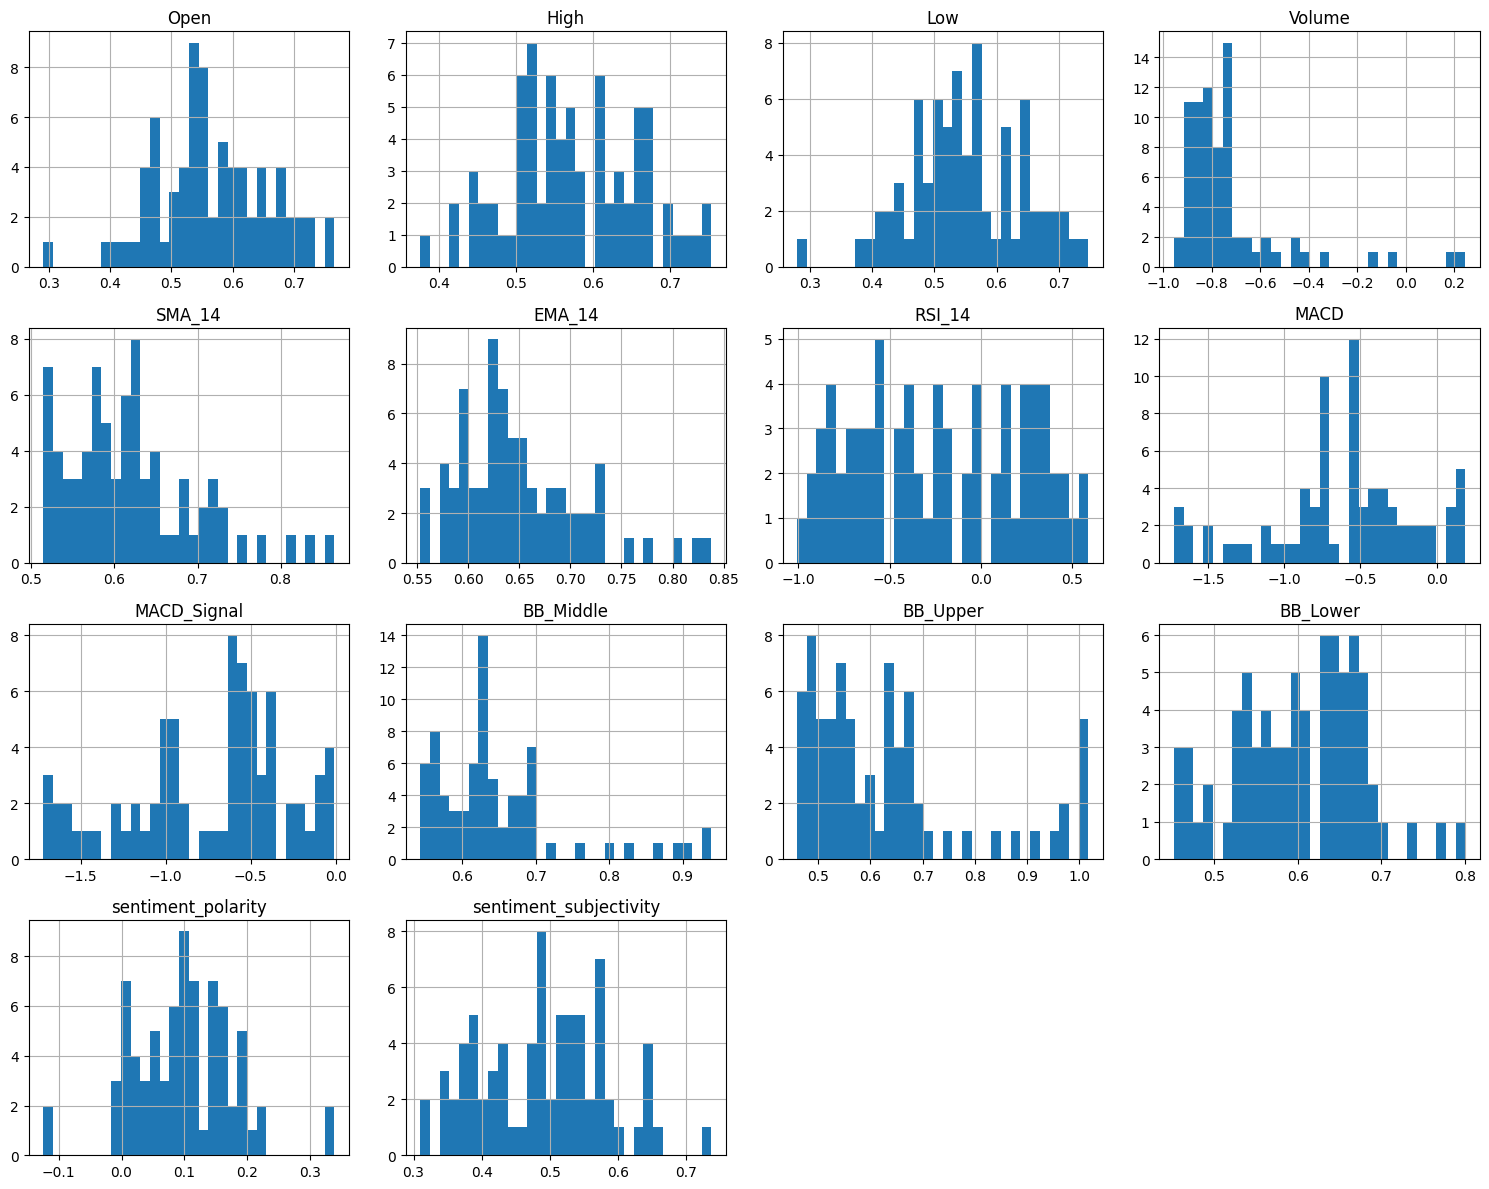

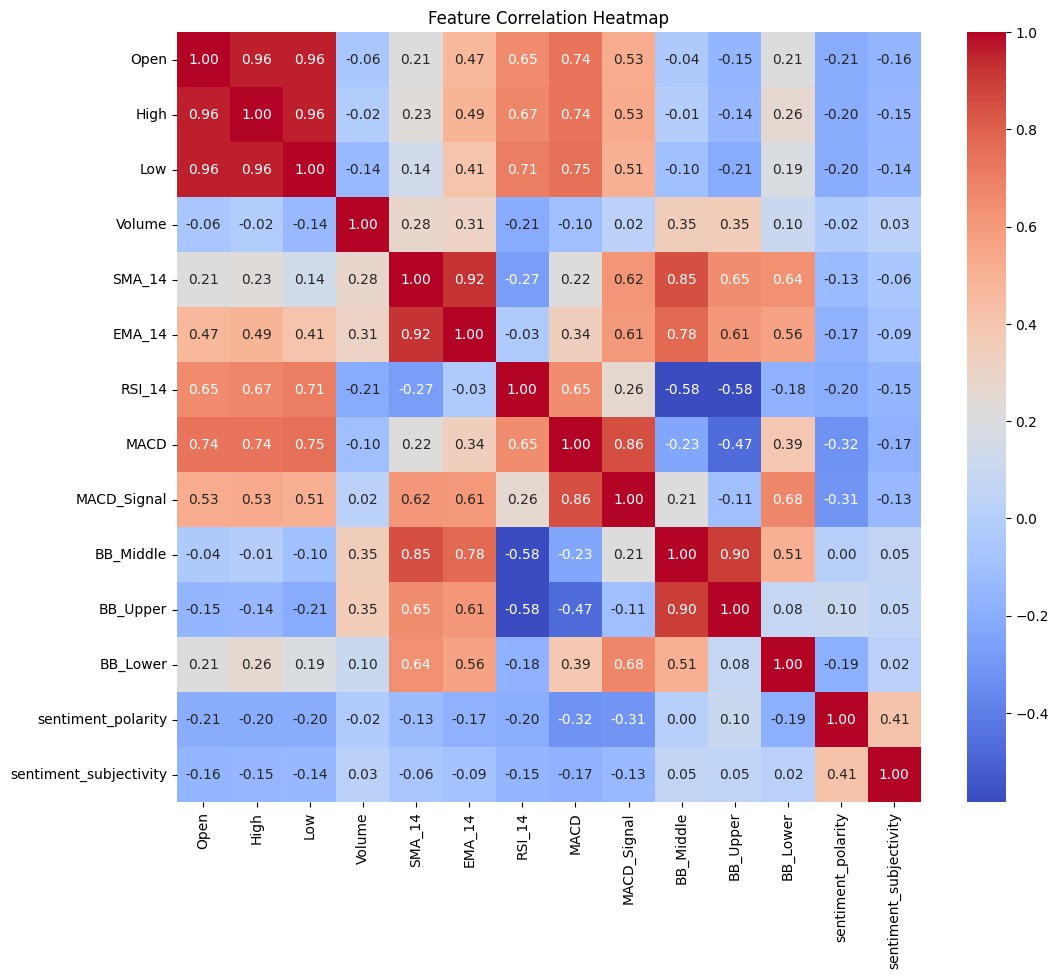

In [22]:
# %% [code]
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base folder where processed stock data is saved
base_folder = '/content/drive/MyDrive/stocks/'

# List all stock folders in the base folder
stock_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
if not stock_folders:
    print("No stock folders found in", base_folder)
else:
    print("Available stock tickers:")
    for i, stock in enumerate(stock_folders):
        print(f"{i + 1}. {stock}")

    # Let the user select a stock ticker by index
    choice = int(input("Enter the number of the stock ticker to inspect: ")) - 1
    selected_stock = stock_folders[choice]
    stock_path = os.path.join(base_folder, selected_stock)
    print(f"Selected stock: {selected_stock}")

    # Ask the user which dataset to inspect (train, val, or test)
    dataset_choice = input("Enter which dataset to inspect (train/val/test): ").strip().lower()
    file_name = f"{selected_stock}_{dataset_choice}.csv"
    file_path = os.path.join(stock_path, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
    else:
        # Load the preprocessed DataFrame
        df_scaled = pd.read_csv(file_path)
        print(f"\nLoaded data from: {file_path}")

        # 1. Print overall summary statistics
        print("\nOverall Summary Statistics:")
        print(df_scaled.describe())

        # 2. Check sentiment columns ranges
        if 'sentiment_polarity' in df_scaled.columns:
            min_pol = df_scaled['sentiment_polarity'].min()
            max_pol = df_scaled['sentiment_polarity'].max()
            print("\nSentiment Polarity range:", min_pol, "to", max_pol)
        else:
            print("\n'sentiment_polarity' column not found.")

        if 'sentiment_subjectivity' in df_scaled.columns:
            min_subj = df_scaled['sentiment_subjectivity'].min()
            max_subj = df_scaled['sentiment_subjectivity'].max()
            print("Sentiment Subjectivity range:", min_subj, "to", max_subj)
        else:
            print("'sentiment_subjectivity' column not found.")

        # 3. Check scaling on non-sentiment features
        sentiment_cols = ['sentiment_polarity', 'sentiment_subjectivity']
        non_sentiment_cols = [col for col in df_scaled.columns if col not in sentiment_cols]
        print("\nNon-sentiment Features Scaling Check:")
        for col in non_sentiment_cols:
            mean_val = df_scaled[col].mean()
            std_val = df_scaled[col].std()
            print(f"{col}: mean = {mean_val:.2f}, std = {std_val:.2f}")

        # 4. Plot histograms for all features
        df_scaled.hist(bins=30, figsize=(15, 12))
        plt.tight_layout()
        plt.show()

        # 5. Plot a correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(df_scaled.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title("Feature Correlation Heatmap")
        plt.show()


In [64]:
# %% [code]
import os
import numpy as np
import pandas as pd
import pickle
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the base folder where processed data is saved
base_folder = '/content/drive/MyDrive/stocks/'

# List available stock folders (each folder corresponds to a ticker)
stock_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
if not stock_folders:
    print("No stock folders found in", base_folder)
    raise SystemExit

print("Available stock tickers:")
for i, stock in enumerate(stock_folders):
    print(f"{i + 1}. {stock}")

# Prompt user to select a ticker
choice = int(input("Enter the number of the stock ticker to inspect: ")) - 1
selected_ticker = stock_folders[choice]
ticker_folder = os.path.join(base_folder, selected_ticker)
print(f"Selected ticker: {selected_ticker}")

# Define file paths for the saved numpy arrays and scalers
files = {
    "X_train": os.path.join(ticker_folder, "X_train.npy"),
    "X_val": os.path.join(ticker_folder, "X_val.npy"),
    "X_test": os.path.join(ticker_folder, "X_test.npy"),
    "y_train": os.path.join(ticker_folder, "y_train.npy"),
    "y_val": os.path.join(ticker_folder, "y_val.npy"),
    "y_test": os.path.join(ticker_folder, "y_test.npy"),
    "scaler_x": os.path.join(ticker_folder, "scaler_x_stock.pkl"),
    "scaler_y": os.path.join(ticker_folder, "scaler_y.pkl")
}

# Check that all files exist
missing = [fname for key, fname in files.items() if not os.path.exists(fname)]
if missing:
    print("❌ Missing files:", missing)
    raise SystemExit
else:
    print("✅ All expected files are present.")

# Load the datasets
X_train = np.load(files["X_train"])
X_val   = np.load(files["X_val"])
X_test  = np.load(files["X_test"])
y_train = np.load(files["y_train"])
y_val   = np.load(files["y_val"])
y_test  = np.load(files["y_test"])

# Load scalers
with open(files["scaler_x"], "rb") as f:
    scaler_x = pickle.load(f)
with open(files["scaler_y"], "rb") as f:
    scaler_y = pickle.load(f)

print("\n📊 Dataset Shapes:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

# Define a function to compute summary statistics for a given array (flattening X if needed)
def summarize_array(arr, name="Array"):
    if arr.ndim > 2:  # For 3D arrays
        arr_flat = arr.reshape(arr.shape[0], -1)
    else:
        arr_flat = arr
    summary = {
        "mean": np.mean(arr_flat, axis=0),
        "std": np.std(arr_flat, axis=0),
        "min": np.min(arr_flat, axis=0),
        "max": np.max(arr_flat, axis=0)
    }
    print(f"\n{name} Summary Statistics:")
    print("Mean:", summary["mean"])
    print("Std :", summary["std"])
    print("Min :", summary["min"])
    print("Max :", summary["max"])
    return summary

# Summarize X datasets (for features)
sum_X_train = summarize_array(X_train, "X_train")
sum_X_val   = summarize_array(X_val, "X_val")
sum_X_test  = summarize_array(X_test, "X_test")

# Summarize y datasets (target)
sum_y_train = summarize_array(y_train, "y_train")
sum_y_val   = summarize_array(y_val, "y_val")
sum_y_test  = summarize_array(y_test, "y_test")

# Print sample values for a quick check
sample_check = {
    # Use X_train[0, :] instead of X_train[0, 0, :]
    "X_train_sample": X_train[0, :].tolist(),
    "y_train_sample": y_train[0].tolist() if np.ndim(y_train[0]) > 0 else float(y_train[0]),
    "X_val_sample": X_val[0, :].tolist(),
    "y_val_sample": y_val[0].tolist() if np.ndim(y_val[0]) > 0 else float(y_val[0]),
    "X_test_sample": X_test[0, :].tolist(),
    "y_test_sample": y_test[0].tolist() if np.ndim(y_test[0]) > 0 else float(y_test[0]),
}
print("\n🔹 Sample Output Check (Send this back to me if needed):")
print(sample_check)

# Additional print to show scaler details (optional)
print("\nScaler_x mean and scale (first 5 features):")
print("Mean:", scaler_x.mean_[:5])
print("Scale:", scaler_x.scale_[:5])

print("\nScaler_y mean and scale:")
print("Mean:", scaler_y.mean_)
print("Scale:", scaler_y.scale_)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available stock tickers:
1. QQQ
2. SPY
3. TSLA
4. MSFT
Enter the number of the stock ticker to inspect: 4
Selected ticker: MSFT
✅ All expected files are present.

📊 Dataset Shapes:
X_train: (350, 14), X_val: (75, 14), X_test: (75, 14)
y_train: (350, 1), y_val: (75, 1), y_test: (75, 1)

X_train Summary Statistics:
Mean: [ 0.06204015  0.06058593  0.05237068 -0.58358756  0.003524    0.05396425
  0.06834865  0.09618415  0.05230879 -0.0237263  -0.09518707  0.00558791
  0.12995412  0.43341186]
Std : [0.47713903 0.48566781 0.47597068 0.28096062 0.54142829 0.5205527
 0.40103873 0.475794   0.50050542 0.55826633 0.56647005 0.53661922
 0.06427872 0.07364257]
Min : [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -0.06285962  0.20724206]
Max : [1.         1.         1.         1.         1.

AttributeError: 'MinMaxScaler' object has no attribute 'mean_'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


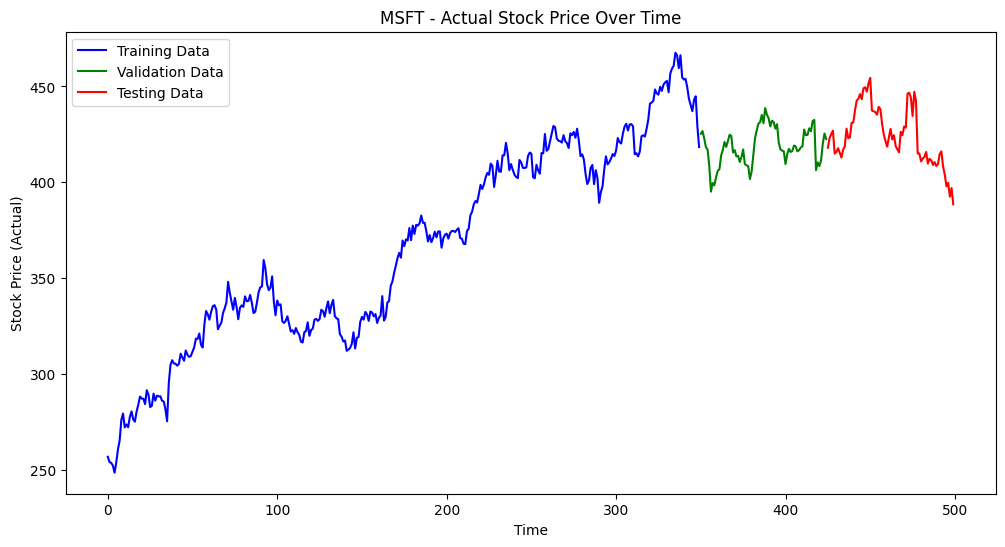

✅ Stock price plot generated successfully!


In [67]:
# %% [code]
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define your ticker folder path (replace "QQQ" with your stock ticker folder)
stock_ticker = "MSFT"
base_path = "/content/drive/MyDrive/stocks"
stock_path = os.path.join(base_path, stock_ticker)

# 3. Load the NumPy arrays from the ticker folder
X_train = np.load(os.path.join(stock_path, "X_train.npy"))
X_val   = np.load(os.path.join(stock_path, "X_val.npy"))
X_test  = np.load(os.path.join(stock_path, "X_test.npy"))
y_train = np.load(os.path.join(stock_path, "y_train.npy"))
y_val   = np.load(os.path.join(stock_path, "y_val.npy"))
y_test  = np.load(os.path.join(stock_path, "y_test.npy"))

# 4. Load the scaler for the target variable (y)
scaler_y_path = os.path.join(stock_path, "scaler_y.pkl")
scaler_y = joblib.load(scaler_y_path)

# 5. Ensure the target arrays are 2D
y_train = y_train.reshape(-1, 1)
y_val   = y_val.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# 6. Inverse transform the target values to get actual prices
y_train_unscaled = scaler_y.inverse_transform(y_train)
y_val_unscaled   = scaler_y.inverse_transform(y_val)
y_test_unscaled  = scaler_y.inverse_transform(y_test)

# 7. Plot the actual stock prices over time
plt.figure(figsize=(12,6))

# Plot training data
plt.plot(y_train_unscaled, label="Training Data", color="blue")

# Plot validation data (shifted forward by len(y_train_unscaled))
plt.plot(range(len(y_train_unscaled), len(y_train_unscaled) + len(y_val_unscaled)),
         y_val_unscaled, label="Validation Data", color="green")

# Plot testing data (shifted forward by len(y_train_unscaled) + len(y_val_unscaled))
plt.plot(range(len(y_train_unscaled) + len(y_val_unscaled),
               len(y_train_unscaled) + len(y_val_unscaled) + len(y_test_unscaled)),
         y_test_unscaled, label="Testing Data", color="red")

plt.xlabel("Time")
plt.ylabel("Stock Price (Actual)")
plt.title(f"{stock_ticker} - Actual Stock Price Over Time")
plt.legend()
plt.show()

print("✅ Stock price plot generated successfully!")
